# Epidemic Simulation in a Central Force Field

In an epidemic simulation, a group of agents are allowed to randomly move. One of these agents will be infected and he can transmit that to neighbours within some radius around them. An infection is passed only to a *susceptible* agent. After a time, the *infected* agent become *recovered* and removed from the susceptible community.

Here, the agents are living in a central force field, $f(r)$. i.e., these agents are pulled towards a central location. In real life, this may correspond to a place where people visit regularly, such as a mall. In the force field, movement of the agents are given by the equations of motion, 

$$ \frac{{\rm d}{\bf x}_i}{{\rm d}t} = {\bf v}_i \quad \text{and} \quad \frac{{\rm d}{\bf v}_i}{{\rm d}t} = f({\bf x}_i) \hat{\bf x}_i $$

I will be using a *gaussian* force field of the form

$$ f(r) = -f_0 \exp \left( -\frac{(r / r_0)^2}{w} \right) $$

where $r = \vert {\bf x}_i - {\bf x}_f \vert$ with ${\bf x}_f$ is the centre of the force field.

In [3]:
from itertools import product
import numpy as np

class community:
    """ a group of random walking agents """

    def __init__(self, n: int, v0: float = 1.0, lim: float = 100.0, rinf: float = 0.01, dt: float = 0.1) -> None:    
        self.n       = n                   # number of agents
        self.lim     = lim                 # space limits
        self.rinf    = self.lim * rinf     # infection radius
        self.pinf    = 0.0                 # infection probability
        self.trec    = 0.0                 # recovery time
        self.time = 0.0
        self.dt      = dt                  # time step for integration
        
        self.fcentre    = np.array([0.0, 0.0]) # centre of the force field
        self.f0, self.w = 0.0, 0.0             # force parameters
        self.soft     = 0.1                    # softening value

        self.e0, self.r0 = 1.0, 0.01 * self.lim # agent force parameters

        self.subdiv   = 10  # grid subdivisions
        self.cellsize = self.lim / self.subdiv

        if self.rinf > self.cellsize:
            raise ValueError("rinf cannot greater than cellsize")

        # create random positions
        self.pos = np.random.uniform(0.0, self.lim, (self.n, 2))

        # create random velocities
        angle    = np.random.uniform(0.0, 2*np.pi, self.n)
        self.vel = v0 * np.array([np.cos(angle), np.sin(angle)]).T

        # infection status: all are susceptible now
        # 0 -> susceptible, 1 -> infected, 2 -> recovered
        self.state = np.zeros(self.n, dtype = 'int') 
        self.t2rec = np.zeros(self.n) # time left to recover

        self.gridify()

        self.cforce_on   = False
        self.aforce_on   = False
        self.has_disease = False

    def config_cforce(self, f0: float = ... , w: float = ..., centre: tuple = ...) -> None:
        """ create a central force field """
        self.fcentre = self.fcentre if centre is ... else self.lim * np.asarray(centre)
        self.f0      = self.f0 if f0 is ... else f0
        self.w       = self.w if w is ... else w

    def config_aforce(self, e0: float = ... , r0: float = ... ) -> None:
        """ configure agent force """
        self.e0 = self.e0 if e0 is ... else e0
        self.r0 = self.r0 if r0 is ... else r0 * self.lim

    def config_disease(self, pinf: float = 0.2, trec: float = 10) -> None:
        """ configure the disease """
        self.pinf, self.trec = pinf, trec
        self.has_disease     = True

    def infect_random(self) -> None:
        """ infect a random agent. """
        if not self.has_disease:
            self.config_disease()

        i = np.random.randint(0, self.n)
        while self.state[i] != 0:
            i = np.random.randint(0, self.n)
        self.state[i] = 1
        self.t2rec[i] = self.trec

    def move(self) -> None:
        """ move the agents by one step. """
        # using leapfrog integration
        self.pos = self.pos + self.vel * self.dt * 0.5 # postion half-step

        # get the acceleration / force
        acc = 0.0
        if self.cforce_on: # acceleration due to the central force
            acc += self.central_acc(self.pos)
        if self.aforce_on: # acceleration due to agent forces
            acc += self.agent_acc(self.pos) 

        self.vel = self.vel * (1 + 0.05 * np.random.uniform(-1, 1, size = self.vel.shape)) + acc * self.dt # velocity step

        self.pos = self.pos + self.vel * self.dt * 0.5 # postion half-step

        # put reflection boundary conditions
        mask            = (self.pos  < 0) # crossing the left/bottom boundary
        self.pos[mask]  = 0
        self.vel[mask] *= -0.5

        mask            = (self.pos > self.lim) # crossing the right/top boundary
        self.pos[mask]  = self.lim
        self.vel[mask] *= -0.5

        self.gridify() # re-grid

        self.update_state() # update state

        self.time += self.dt

    def central_acc(self, pos: float) -> float:
        """ acceleration due to central force """
        sep = pos - self.fcentre
        r   = np.sqrt(np.sum(sep**2, -1) + self.soft**2)
        acc = -self.f0 * np.exp(-(r / self.lim)**2 / self.w) / r
        acc = acc[:, None] * sep # acceleration = force / mass
        return acc

    def agent_acc(self, pos: float) -> float: # TODO
        """ acceleration due to agent force. """
        # return 0.0
        acc = np.zeros_like(pos)
        for p in pos:
            near = self.nearest(p)
            if not len(near):
                continue
            sep = p - self.pos[near,:]
            r   = np.sqrt(np.sum(sep**2, -1))

            # filter non-zero values
            mask         = (r > 1e-8)
            near, r, sep = near[mask], r[mask], sep[mask,:]

            acc_ = - self.e0 * np.exp(-(r / self.r0)**2) / r
            acc[near, :] += acc_[:, None] * sep 
        return acc

    def gridify(self) -> None:
        """ arrange the agents in a grid. """
        subdiv   = self.subdiv
        cellsize = self.cellsize

        cellpos = (self.pos // cellsize).astype(int)

        cells, inv = np.unique(cellpos, axis = 0, return_inverse = True)
        
        # grid = {(i,j): [] for i in range(subdiv) for j in range(subdiv)}
        grid = {}
        for i, (ci, cj) in enumerate(cells):
            grid[ci, cj] = np.where(inv == i)[0]

        self.grid = grid

    def nearest(self, pos: list) -> list:
        """ get the nearest agents to an agent. """
        def clip(x: float, a: float, b: float) -> float:
            """ clip value between a and b """
            return max(a, min(x, b))

        def intersect(cell: tuple, center: list) -> bool:
            """ check if a cell intersect with a cell. """
            r = self.cellsize

            x, y   = cell[0] * r, cell[1] * r
            near_x = clip(center[0], x, x + r)
            near_y = clip(center[1], y, y + r)
            return (center[0] - near_x)**2 + (center[1] - near_y)**2 < r**2

        i, j = (np.asarray(pos) // self.cellsize).astype(int)

        search_cells = product(
                                range(
                                        max(0, i-1),
                                        min(i+2, self.subdiv)
                                     ),
                                range(
                                        max(0, j-1),
                                        min(j+2, self.subdiv)
                                     )
                              )
        neighbours = []
        for cell in search_cells:
            if cell not in self.grid.keys():
                continue
            if not intersect(cell, pos):
                continue
            k     = self.grid[cell]
            pos2  = self.pos[k, :] # others in the cell
            
            
            select, = np.where(np.sqrt(np.sum((pos2 - pos)**2, axis = -1)) <= self.cellsize**2)
            neighbours = neighbours + list(k[select])
        return np.array(neighbours)

    def update_state(self) -> None:
        """ update the status. """
        # infect nearest heighbours
        inf = np.where(self.state == 1)[0] # infected agents
        if not len(inf):
            return

        for i in inf:
            near = self.nearest(self.pos[i,:])

            exp  = near[self.state[near] == 0] # nearset exposed
            prob = np.random.uniform(0, 1, exp.shape)

            to_infect = exp[(prob < self.pinf) & (np.sum((self.pos[i,:] - self.pos[exp,:])**2, -1) < self.rinf**2)]

            self.state[to_infect] = 1
            self.t2rec[to_infect] = self.trec

        # update recovery time
        self.t2rec[inf] -= self.dt 

        # recover some agents
        to_recover, = np.where(self.t2rec < 0.)
        self.t2rec[to_recover] = 0.0
        self.state[to_recover] = 2

    def switch_cforce(self, state: bool) -> None:
        """ switch on/off the central force. """
        self.cforce_on = state

    def switch_aforce(self, state: bool) -> None:
        """ switch on/off the agent force. """
        self.aforce_on = state



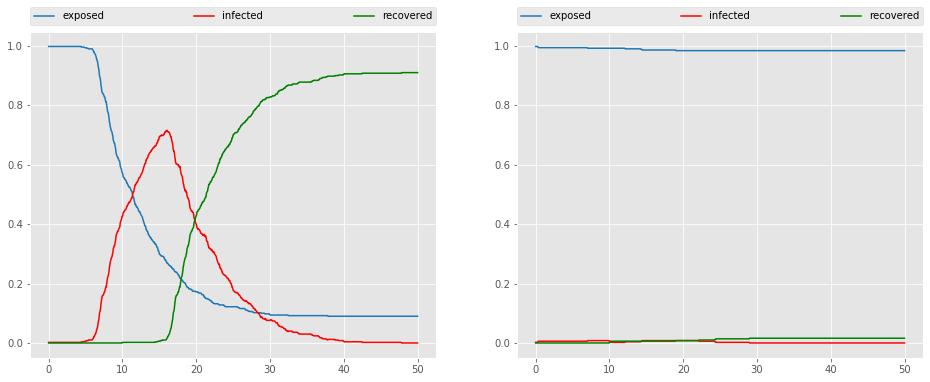

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
plt.style.use('ggplot')

def sample_animation():
    """ sample animation of the simulation """
    com = community(n = 500, dt = 0.01)

    com.config_cforce(f0 = 10.0, w = 0.05, centre = [0.5, 0.5])

    com.config_disease(pinf = 0.2, trec = 10.0)

    com.switch_cforce(True)

    # infect 10 agents in random:
    for i in range(10):
        com.infect_random()

    fig, ax = plt.subplots(figsize = [8,8])
    ax.axis([-2., com.lim + 2, -2., com.lim + 2])

    line_e, = ax.plot([], [], 'o', ms = 3, color = 'black')
    line_i, = ax.plot([], [], 'o', ms = 3, color = 'red')
    line_r, = ax.plot([], [], 'o', ms = 3, color = 'tab:blue')
    box,  = ax.plot([], [], lw = 2, color = 'gray')

    def animate(i):
        state = com.state
        line_e.set_data(com.pos[state == 0,0], com.pos[state == 0,1])
        line_i.set_data(com.pos[state == 1,0], com.pos[state == 1,1])
        line_r.set_data(com.pos[state == 2,0], com.pos[state == 2,1])
        box.set_data([0, com.lim, com.lim, 0, 0], [0, 0, com.lim, com.lim, 0])
        com.move()

    ani = anim.FuncAnimation(fig, animate, frames = 500)
    plt.close()
    
    return ani


def sample_evolution(tmax: float = 50.0, _animate: bool = False):
    """ sample simulation """
    com1 = community(n = 500, dt = 0.05)
    com1.config_cforce(f0 = 10.0, w = 0.05, centre = [0.5, 0.5])
    com1.config_disease(pinf = 0.2, trec = 10.0)

    com2 = community(n = 500, dt = 0.05)
    com1.config_disease(pinf = 0.2, trec = 10.0)
    com1.switch_cforce(True)
    
    # get the evolution
    com1.infect_random()
    com2.infect_random()

    t1, t2, sir1, sir2 = [], [], [], []
    while com1.time < tmax:
        state1 = com1.state
        sir1.append(
                        [
                            np.sum(np.where(state1 == 0, 1, 0)), # exposed
                            np.sum(np.where(state1 == 1, 1, 0)), # infected
                            np.sum(np.where(state1 == 2, 1, 0)), # recovred
                        ]
                   )
        t1.append(com1.time)
        com1.move()

        
    while com2.time < tmax:
        state2 = com2.state
        sir2.append(
                        [
                            np.sum(np.where(state2 == 0, 1, 0)), # exposed
                            np.sum(np.where(state2 == 1, 1, 0)), # infected
                            np.sum(np.where(state2 == 2, 1, 0)), # recovred
                        ]
                   )
        t2.append(com2.time)
        com2.move()
    
    t1, t2, sir1, sir2 = np.asarray(t1), np.asarray(t2), np.asarray(sir1) / com1.n, np.asarray(sir2) / com2.n

    fig, (ax, ax2) = plt.subplots(1, 2, figsize = [16, 6])

    ax.plot(t1, sir1[:,0], color = 'tab:blue', label = 'exposed')
    ax.plot(t1, sir1[:,1], color = 'red', label = 'infected')
    ax.plot(t1, sir1[:,2], color = 'green', label = 'recovered')

    ax.legend(
                bbox_to_anchor = (0., 1.02, 1., .102), loc = 'lower left',
                ncol = 3, mode = "expand", borderaxespad = 0.
            )

    ax2.plot(t2, sir2[:,0], color = 'tab:blue', label = 'exposed')
    ax2.plot(t2, sir2[:,1], color = 'red', label = 'infected')
    ax2.plot(t2, sir2[:,2], color = 'green', label = 'recovered')

    ax2.legend(
                bbox_to_anchor = (0., 1.02, 1., .102), loc = 'lower left',
                ncol = 3, mode = "expand", borderaxespad = 0.
            )
    
    plt.show()



# ani = sample_animation()

# from IPython.display import HTML
# HTML(ani.to_jshtml())

sample_evolution(50.0)